In [34]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [35]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')

In [60]:
env_name = 'cartpole'

In [61]:
!ls -lt ../experiments

total 620
drwxrwxr-x  2 viraj viraj 36864 Aug 25 18:28 working_pendulum1
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:27 test_improve
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:27 test2
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:27 test0
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:27 test
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 rbax_pend3
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 rbax_pend2
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 rbax_pend
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 profile
drwxrwxr-x  6 viraj viraj  4096 Aug 25 18:26 uniform_random_test_1k_2021-07-28
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 pendulum_new_longer
drwxrwxr-x  2 viraj viraj  4096 Aug 25 18:26 pendulum_new
drwxrwxr-x  3 viraj viraj  4096 Aug 25 18:26 try_teleport_2021-08-14
drwxrwxr-x  3 viraj viraj  4096 Aug 25 18:26 try_uniform_sampling_1k_2021-07-27
drwxrwxr-x  3 viraj viraj  4096 Aug 25 18:26 try_uniform_sampling_2021-07-27
drwxrwxr-x  3 viraj viraj  4096 Aug 25 18:26 try_uniform_sampling_2k_

In [62]:
! ls -lt ../../bac-baselines/experiments

total 28
drwxrwxr-x 3 viraj viraj 4096 Aug 25 18:21 sac_pendulum_2021-08-24
drwxrwxr-x 3 viraj viraj 4096 Aug 25 18:21 td3_cartpole_2021-08-24
drwxrwxr-x 3 viraj viraj 4096 Aug 25 18:21 td3_pendulum_2021-08-24
drwxrwxr-x 4 viraj viraj 4096 Aug 25 18:21 default_2021-08-24
drwxrwxr-x 3 viraj viraj 4096 Aug 25 18:21 ppo_cartpole_2021-08-25
drwxrwxr-x 3 viraj viraj 4096 Aug 25 18:21 ppo_pendulum_2021-08-24
drwxrwxr-x 5 viraj viraj 4096 Aug 25 18:21 sac_cartpole_2021-08-24


In [63]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'MBRL': 'default_2021-08-16/16-03-38',
         'SAC': 'sac_pendulum_2021-08-24/18-06-22'
         
        }

In [64]:
cartpole_paths = {
         'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         'MBRL': 'cartpole_multistart_mbrl_2021-08-18/23-45-13/',
         'SAC': 'sac_cartpole_2021-08-24/18-32-18/',
}

In [65]:
all_paths = {"cartpole": cartpole_paths, "pendulum": pend_paths}
paths = all_paths[env_name]
gt = {"pendulum": -200, "cartpole": -12.5}
gt_val = gt[env_name]

In [66]:
data = {}
for key, path in paths.items():
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = pickle.load(f)
        continue
    baseline_exp_path = baseline_path / path / 'evaluations.npz'
    if baseline_exp_path.exists():
        data_res = np.load(baseline_exp_path)
        reformatted_data = {'Eval Returns': data_res['results'], 'Eval ndata': data_res['timesteps']}
        data[key] = reformatted_data
        continue
    print(f"Data for {key} not found!")

dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['Eval Returns', 'Eval ndata'])


Text(0.5, 0.98, 'Control Performance on cartpole')

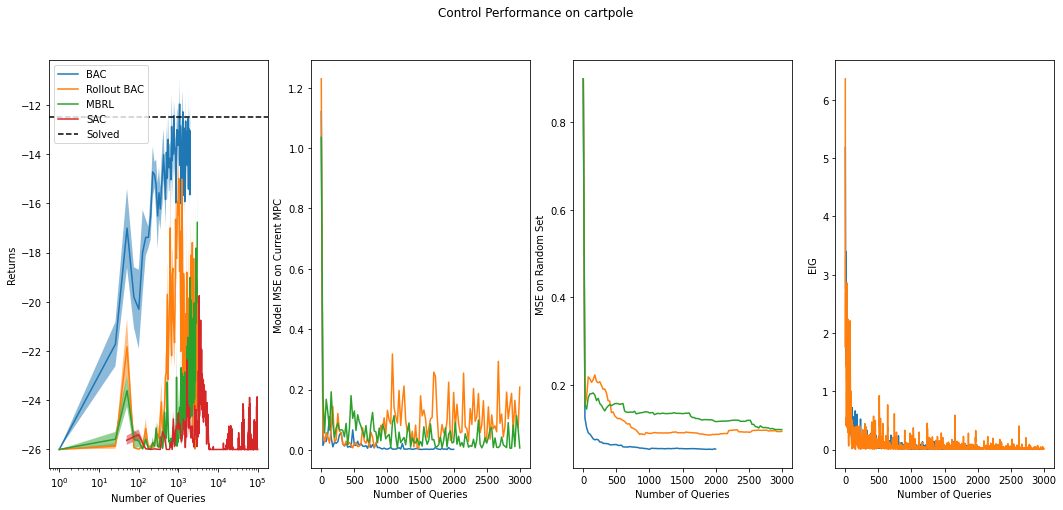

In [67]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    print(vals.keys())
    returns = np.array(vals['Eval Returns'])
    rmean = returns.mean(axis=1)
    rstderr = returns.std(axis=1) / np.sqrt(returns.shape[1])
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
ax1.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")


Text(0.5, 0.98, 'Control Performance on cartpole')

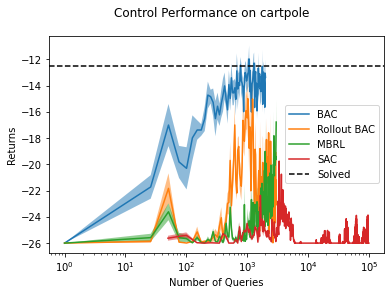

In [68]:
fig, ax = plt.subplots()
for key, vals in data.items():
    returns = np.array(vals['Eval Returns'])
    rmean = returns.mean(axis=1)
    rstderr = returns.std(axis=1) / np.sqrt(returns.shape[1])
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label='Solved')
ax.legend()
ax.set_xscale('log')
fig.suptitle(f"Control Performance on {env_name}")